In [1]:
#importy
import sklearn
import pandas as pd
import numpy as np
import joblib


In [2]:
# pobranie danych z onedrive
import static_ev as ev
from Funkcje.data_import import load_onedrive_csv

indeksy_df = load_onedrive_csv(ev.indeksy_url)
kombinacje_df = load_onedrive_csv(ev.kombinacje_url)

Pobieranie danych z OneDrive...
Pomyślnie zdekodowano przy użyciu utf-8
Wczytano 108782 wierszy i 266 kolumn
Pobieranie danych z OneDrive...
Pomyślnie zdekodowano przy użyciu windows-1250
Wczytano 386148 wierszy i 13 kolumn


In [3]:
# czyszczenie danych
indeksy_df = indeksy_df[['ID', 'INDEKS', 'NAZWA', 'KOMB_ID']].copy()
kombinacje_df = kombinacje_df[[
    'SEGM_ID', 'KOMB_ID', 'POZYCJA_SEG', 'SLIT_ID', 'SLOW_ID', 
    'KOD', 'OPIS', 'ZALEZNY_OD_ID', 'NAZWA_SLOW', 'ZALEZNY_OD_SLOW_ID'
]].copy()

# zostawiamy tylko te wiersze, które mają wartość w kolumnie KOMB_ID
indeksy_df = indeksy_df.dropna(subset=['KOMB_ID'])

# zostawiamy tylko te indeksy, które zaczynają się od 'M' - Materialy
indeksy_df = indeksy_df[indeksy_df['INDEKS'].str.startswith('M')]

# 

# wyświetlenie wyników czyszczenia
print(f"Liczba wierszy w indeksy_df po czyszczeniu: {len(indeksy_df)}")
print(f"Liczba wierszy w kombinacje_df: {len(kombinacje_df)}")

# Sprawdź ile jest NaN w POZYCJA_SEG
print("NaN w POZYCJA_SEG:")
print(kombinacje_df['POZYCJA_SEG'].isna().sum())
print("\nUnikalne wartości:")
print(kombinacje_df['POZYCJA_SEG'].value_counts(dropna=False))

Liczba wierszy w indeksy_df po czyszczeniu: 67085
Liczba wierszy w kombinacje_df: 386148
NaN w POZYCJA_SEG:
0

Unikalne wartości:
POZYCJA_SEG
1    64838
2    64262
3    64262
4    64262
5    64262
6    64262
Name: count, dtype: int64


In [4]:
#tokenizacja kolumny nazwa w ramce indeksy_df
from Funkcje.tokenizacja import tokenize_column
from Funkcje.tokenizacja import pad_tokens

indeksy_df_token = tokenize_column(indeksy_df, column_name='NAZWA', model='gpt-3.5-turbo')
max_tokens = indeksy_df_token['NAZWA_TOKEN_COUNT'].max()
indeksy_df_token['NAZWA_TOKENS_PADDED'] = pad_tokens(indeksy_df_token['NAZWA_TOKENS'].tolist(), pad_token_id=0, max_tokens=max_tokens)


Tokenizacja zakończona. Średnia liczba tokenów: 26.47
Maksymalna liczba tokenów: 105
Minimalna liczba tokenów: 2


In [5]:
#marge
merged_df = indeksy_df_token.merge(kombinacje_df, on='KOMB_ID', how='left')
# usuniecie kolumn: opis, zalezny_od_id, zalezny_od_slow_id
merged_df = merged_df.drop(columns=['ZALEZNY_OD_ID', 'ZALEZNY_OD_SLOW_ID'])
#usuniecie wierszy z brakujaca wartoscia w kolumnie KOD
merged_df = merged_df.dropna(subset=['KOD'])    
#liczba wierszy po usunieciu brakujacych wartosci
print(f"Liczba wierszy w merged_df po usunieciu brakujacych wartosci: {len(merged_df)}")

Liczba wierszy w merged_df po usunieciu brakujacych wartosci: 402436


In [6]:
#pivot danych
merged_df['POZYCJA_SEG'] = pd.to_numeric(merged_df['POZYCJA_SEG'], errors='coerce').astype('Int64')
merged_df = merged_df.pivot_table(index=['ID', 'INDEKS', 'NAZWA', 'KOMB_ID'], 
                                  columns=['POZYCJA_SEG'], 
                                  values=['SLIT_ID', 'KOD', 'OPIS', 'NAZWA_SLOW','SLOW_ID', ], 
                                  aggfunc='first')
merged_df.columns = ['{}_{}'.format(col[0], col[1]) for col in merged_df.columns]
merged_df = merged_df.reset_index()
print(f"Liczba wierszy w merged_df: {len(merged_df)}")
# liczba unikalnych wierszy w merged_df
print(f"Liczba unikalnych wierszy w merged_df: {len(merged_df.drop_duplicates())}")

# Konwersja kolumn SLIT_ID i SLOW_ID z powrotem na Int64 (nullable integer)
for col in merged_df.columns:
    if col.startswith('SLIT_ID') or col.startswith('SLOW_ID'):
        merged_df[col] = merged_df[col].astype('Int64')
merged_df = merged_df.merge(
    indeksy_df_token[['ID', 'NAZWA_TOKEN_COUNT','NAZWA_TOKENS', 'NAZWA_TOKENS_PADDED']], 
    on='ID', 
    how='left'
)

Liczba wierszy w merged_df: 67079
Liczba unikalnych wierszy w merged_df: 67079


In [20]:
lista_kolumn = merged_df.columns.tolist()
print(lista_kolumn)
#Werfikacja czy istnieją kolumny z wartościami NaN w kolumnach SLIT_ID
for col in lista_kolumn:
    if col.startswith('SLIT_ID'):
        nan_count = merged_df[col].isna().sum()
        if nan_count > 0:
            print(f'Kolumna {col} ma {nan_count} wartości NaN')
#Wyświetlenie wierszy z NaN w SLIT_ID_1, SLIT_ID_2, SLIT_ID_3
print(merged_df[merged_df[['SLIT_ID_1', 'SLIT_ID_2', 'SLIT_ID_3']].isna().any(axis=1)]) 

['ID', 'INDEKS', 'NAZWA', 'KOMB_ID', 'KOD_1', 'KOD_2', 'KOD_3', 'KOD_4', 'KOD_5', 'KOD_6', 'NAZWA_SLOW_1', 'NAZWA_SLOW_2', 'NAZWA_SLOW_3', 'NAZWA_SLOW_4', 'NAZWA_SLOW_5', 'NAZWA_SLOW_6', 'OPIS_1', 'OPIS_2', 'OPIS_3', 'OPIS_4', 'OPIS_5', 'SLIT_ID_1', 'SLIT_ID_2', 'SLIT_ID_3', 'SLIT_ID_4', 'SLIT_ID_5', 'SLIT_ID_6', 'SLOW_ID_1', 'SLOW_ID_2', 'SLOW_ID_3', 'SLOW_ID_4', 'SLOW_ID_5', 'SLOW_ID_6', 'NAZWA_TOKEN_COUNT', 'NAZWA_TOKENS', 'NAZWA_TOKENS_PADDED']
Kolumna SLIT_ID_2 ma 1 wartości NaN
Kolumna SLIT_ID_3 ma 1 wartości NaN
Kolumna SLIT_ID_4 ma 34 wartości NaN
Kolumna SLIT_ID_5 ma 1 wartości NaN
Kolumna SLIT_ID_6 ma 1 wartości NaN
           ID                           INDEKS  \
63997  111245  M-HIP-UCH-RCP1-338-FEZN-6-78470   

                                         NAZWA  KOMB_ID KOD_1 KOD_2 KOD_3  \
63997  UCHWYT RCP1-338 FEZN PP / RCPR1-338 FKB  92338.0     M   NaN   NaN   

      KOD_4 KOD_5 KOD_6  ... SLIT_ID_6 SLOW_ID_1 SLOW_ID_2 SLOW_ID_3  \
63997   NaN   NaN   NaN  ...      <NA>

In [8]:
indeksy_model_Seg12 = merged_df[['ID', 'INDEKS', 'NAZWA', 'NAZWA_TOKENS_PADDED','NAZWA_TOKEN_COUNT','KOMB_ID',
                                 'SLIT_ID_1', 'KOD_1', 'OPIS_1', 'NAZWA_SLOW_1', 'SLOW_ID_1',
                                'SLIT_ID_2', 'KOD_2', 'OPIS_2', 'NAZWA_SLOW_2', 'SLOW_ID_2']].copy()
#Dodanie kolumny bedącej poączeniem wartości z kolumn SLOW_ID_1.0 i SLOW_ID_2.0 jako string pod nazwa 'Y'
indeksy_model_Seg12['Y'] = indeksy_model_Seg12['SLIT_ID_1'].astype(str) + '_' + indeksy_model_Seg12['SLIT_ID_2'].astype(str)      

In [9]:
#Model_Seg12
from Funkcje.model import train_xgb_model

model_Seg12, y_test, y_pred, accuracy, report, matrix = train_xgb_model(
    indeksy_model_Seg12, 
    n_estimators=277, 
    n_learning_rate=0.09960391279950036, 
    n_max_depth=23, 
    n_test_size=0.2, 
    n_random_state=42
)

print(f'Accuracy: {accuracy}')
print('\nClassification Report:')
print(report)
print('\nConfusion Matrix:')
print(matrix)

Accuracy: 0.9664579606440071

Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.99      0.99       481
           2       0.00      0.00      0.00         0
           3       0.90      0.82      0.86        22
           4       1.00      1.00      1.00         3
           5       0.88      0.85      0.86       177
           6       0.60      0.75      0.67        20
           8       0.94      1.00      0.97        15
          10       0.76      0.96      0.85        26
          11       0.83      0.91      0.87        22
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00        27
          14       0.97      1.00      0.99        37
          16       0.00      0.00      0.00         2
          17       0.73      0.44      0.55        18
          18       1.00      1.00      1.00       847
          19       0.86      0.73      0.79        51
          20       0.91     

In [12]:
from Funkcje.predykcja import predict_interactive

predictions = predict_interactive(model_Seg12, indeksy_model_Seg12, indeksy_model_Seg12, top_n=8)

Tokenizacja zakończona. Średnia liczba tokenów: 2.00
Maksymalna liczba tokenów: 2
Minimalna liczba tokenów: 2

Top 8 przewidywanych klas:
1. 22_31 (Prawdopodobieństwo: 0.9677)
2. 22_81 (Prawdopodobieństwo: 0.0083)
3. 22_72 (Prawdopodobieństwo: 0.0057)
4. 22_97 (Prawdopodobieństwo: 0.0039)
5. 22_28 (Prawdopodobieństwo: 0.0027)
6. 22_69 (Prawdopodobieństwo: 0.0017)
7. 22_35 (Prawdopodobieństwo: 0.0013)
8. 22_107 (Prawdopodobieństwo: 0.0013)


In [ ]:
indeksy_model_Seg3 = merged_df[['ID', 'INDEKS', 'NAZWA', 'NAZWA_TOKENS_PADDED','NAZWA_TOKEN_COUNT','KOMB_ID',
                                 'SLIT_ID_1', 'KOD_1', 'OPIS_1', 'NAZWA_SLOW_1', 'SLOW_ID_1',
                                'SLIT_ID_2', 'KOD_2', 'OPIS_2', 'NAZWA_SLOW_2', 'SLOW_ID_2',
                                'SLIT_ID_3', 'KOD_3', 'OPIS_3', 'NAZWA_SLOW_3', 'SLOW_ID_3'
                                ]].copy()
indeksy_model_Seg3['Y'] = indeksy_model_Seg3['SLIT_ID_3'].astype(str)
# Dodanie do kolumny NAZWA_TOKENS_PADDED jako pierwszne na liscie wartosci z kolumn Slit_ID_1, Slit_ID_2.  
indeksy_model_Seg3['NAZWA_TOKENS_PADDED'] = indeksy_model_Seg3.apply(
    lambda row: [str(row['SLIT_ID_1']), str(row['SLIT_ID_2'])] + row['NAZWA_TOKENS_PADDED'], axis=1
)   
#Usuniecie wierszy ktore zawieraja NaN w kolumnie Y 
indeksy_model_Seg3 = indeksy_model_Seg3.dropna(subset=['SLIT_ID_3'])
#Wyswietlenie wierszy z NaN w SLIT_ID_3
print(indeksy_model_Seg3[indeksy_model_Seg3['SLIT_ID_3'].isna()])



Empty DataFrame
Columns: [ID, INDEKS, NAZWA, NAZWA_TOKENS_PADDED, NAZWA_TOKEN_COUNT, KOMB_ID, SLIT_ID_1, KOD_1, OPIS_1, NAZWA_SLOW_1, SLOW_ID_1, SLIT_ID_2, KOD_2, OPIS_2, NAZWA_SLOW_2, SLOW_ID_2, SLIT_ID_3, KOD_3, OPIS_3, NAZWA_SLOW_3, SLOW_ID_3, Y]
Index: []

[0 rows x 22 columns]


In [34]:
#Model_Seg3

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split    
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
def train_xgb_model_Seg3(data, n_estimators, n_learning_rate, n_max_depth, n_test_size, n_random_state):
    X = np.array(data['NAZWA_TOKENS_PADDED'].tolist())
    y = data['Y'].values

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=n_test_size, random_state=n_random_state)

    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=n_learning_rate,
        max_depth=n_max_depth,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    matrix = confusion_matrix(y_test, y_pred)

    return model, y_test, y_pred, accuracy, report, matrix
model_Seg3, y_test, y_pred, accuracy, report, matrix = train_xgb_model_Seg3(
    indeksy_model_Seg3, 
    n_estimators=300, 
    n_learning_rate=0.1, 
    n_max_depth=26, 
    n_test_size=0.2, 
    n_random_state=42
)

print(f'Accuracy: {accuracy}')
print('\nClassification Report:')
print(report)
print('\nConfusion Matrix:')
print(matrix)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516], got [  0   1   4   5   6   7   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  77  78  79  80  81  82  83  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 162 163 164 166 167 168 169 170
 171 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 248 249 250 251 252 253 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 290 291 292 293 294 295 296 297 298 299 300
 301 302 303 304 306 307 308 309 311 312 313 315 316 317 318 319 320 321
 322 323 324 325 326 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 346 347 348 349 350 351 352 353 354 355 356 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 408 409 410 411 412 413 414 415
 417 418 419 420 421 422 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 444 445 446 447 448 449 450 451 452 453 454
 455 456 457 458 459 460 461 462 463 464 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527
 528 529 530 531 532 534 535 536 537 538 539 540 541]

In [10]:
# przygotowanie ramiki danych do modelu
# dodajemy kolumnę z dwoma pierwszymi segmentami indeksu
indeksy_df_token['Y'] = indeksy_df_token['INDEKS'].str.split('-').str[:2].str.join('-')

# tworzymy ramkę danych do modelu
indeksy_model_1 = indeksy_df_token[['INDEKS', 'NAZWA', 'NAZWA_TOKENS', 'NAZWA_TOKEN_COUNT', 'Y', 'NAZWA_TOKENS_PADDED']].copy()  
indeksy_model_1.head()

,INDEKS,NAZWA,NAZWA_TOKENS,NAZWA_TOKEN_COUNT,Y,NAZWA_TOKENS_PADDED
173,"M-RUR-KOL-76,1-S235-6-46055","KOŁNIERZ Z SZYJKĄ TYP 11 B DN65 76,1X2,9 PN10/...","[56047, 129, 223, 15259, 643, 57, 1901, 70344,...",39,M-RUR,"[56047, 129, 223, 15259, 643, 57, 1901, 70344,..."
869,"M-RUR-ZSC-139,7-X52-6-65355","RURA 139,7X6,3 X52 PSL1 AT 3.1","[49, 41410, 4194, 10125, 11, 22, 55, 21, 11, 1...",21,M-RUR,"[49, 41410, 4194, 10125, 11, 22, 55, 21, 11, 1..."
870,"M-RUR-ZSC-168,3-X52-6-65353","RURA 168,3X6,3 X52 PSL1 AT 3.1","[49, 41410, 4194, 8953, 11, 18, 55, 21, 11, 18...",21,M-RUR,"[49, 41410, 4194, 8953, 11, 18, 55, 21, 11, 18..."
872,"M-RUR-ZSC-168,3-X52-6-65354","RURA 168,3X8 X52 PSL1 AT 3.1","[49, 41410, 4194, 8953, 11, 18, 55, 23, 4194, ...",20,M-RUR,"[49, 41410, 4194, 8953, 11, 18, 55, 23, 4194, ..."
880,M-SRU-POD-M20-0-0-468,PODKŁADKA ZGRUBNA 22 FEZN OGNIOWO POKRYCIE FLU...,"[2089, 18805, 129, 223, 1846, 27542, 1901, 879...",29,M-SRU,"[2089, 18805, 129, 223, 1846, 27542, 1901, 879..."


In [ ]:
#########
# do zastanowania czy z ramki danych usuwać kategorie z małą liczbą próbek(np. mniej niż 5). Na podstawie takich małych zbiorów model może się źle uczyć.
#########
print("Rozkład klas Y:")
print(indeksy_model_1['Y'].value_counts())
print(f"\nLiczba unikalnych kategorii: {indeksy_model_1['Y'].nunique()}")

min_samples = 5
class_counts = indeksy_model_1['Y'].value_counts()
valid_classes = class_counts[class_counts >= min_samples].index
indeksy_model_1_filtered = indeksy_model_1[indeksy_model_1['Y'].isin(valid_classes)].copy()
print("Rozkład klas po filtracji Y:")
print(indeksy_model_1_filtered['Y'].value_counts())
print(f"\nLiczba unikalnych kategorii: {indeksy_model_1_filtered['Y'].nunique()}")

In [11]:
# trenowanie modelu
from Funkcje.model import train_xgb_model

model, y_test, y_pred, accuracy, report, matrix = train_xgb_model(
    indeksy_model_1, 
    n_estimators=277, 
    n_learning_rate=0.09960391279950036, 
    n_max_depth=23, 
    n_test_size=0.2, 
    n_random_state=42
)

print(f'Accuracy: {accuracy}')
print('\nClassification Report:')
print(report)
print('\nConfusion Matrix:')
print(matrix)

#wcześniej zwracalismy bledne metryki. Przy klasyfikacji przede wszystkim liczy sie accuracy i classification report, a nie r2 i mean squared error.
    

Accuracy: 0.9661623313706492

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      0.98      0.99        47
           3       1.00      0.33      0.50         3
           4       0.43      0.27      0.33        11
           5       1.00      1.00      1.00       854
           6       0.88      1.00      0.93         7
           7       0.91      0.62      0.74        50
           8       0.88      0.94      0.91       552
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         2
          11       0.66      0.60      0.62        42
          12       0.00      0.00      0.00         1
          13       0.78      0.78      0.78         9
          14       1.00      1.00      1.00         5
          15       0.97      0.95      0.96        37
          16       0.00      0.00      0.00         1
          17       0.91     

In [ ]:
# optymalizacja hiperparametrów z użyciem Optuna

from Funkcje.optuna_optimizer import optimize_xgb_model
results = optimize_xgb_model(
    indeksy_model_1, 
    n_trials=50,
    n_estimators_range=(100, 300),
    learning_rate_range=(0.01, 0.3),
    max_depth_range=(7, 24)
)   

[I 2025-11-24 07:56:01,310] A new study created in memory with name: no-name-644a782f-470b-483e-9b6a-52e4222e4b3e
[I 2025-11-24 07:57:25,423] Trial 0 finished with value: 0.9637027651486919 and parameters: {'n_estimators': 209, 'learning_rate': 0.027894775544898373, 'max_depth': 17}. Best is trial 0 with value: 0.9637027651486919.
[I 2025-11-24 07:57:25,423] Trial 0 finished with value: 0.9637027651486919 and parameters: {'n_estimators': 209, 'learning_rate': 0.027894775544898373, 'max_depth': 17}. Best is trial 0 with value: 0.9637027651486919.
[I 2025-11-24 07:58:07,254] Trial 1 finished with value: 0.9638518297682045 and parameters: {'n_estimators': 105, 'learning_rate': 0.0728235381886848, 'max_depth': 19}. Best is trial 1 with value: 0.9638518297682045.
[I 2025-11-24 07:58:07,254] Trial 1 finished with value: 0.9638518297682045 and parameters: {'n_estimators': 105, 'learning_rate': 0.0728235381886848, 'max_depth': 19}. Best is trial 1 with value: 0.9638518297682045.
[I 2025-11-24 

Best trial:
  Accuracy: 0.9662
  Params: 
    n_estimators: 277
    learning_rate: 0.09960391279950036
    max_depth: 23


In [ ]:
# ponowne trenowanie modelu z najlepszymi hiperparametrami
from Funkcje.model import train_xgb_model

best_params = results['best_params']
model, y_test, y_pred, accuracy, report, matrix = train_xgb_model(
    indeksy_model_1,
    n_estimators=best_params['n_estimators'],
    n_learning_rate=best_params['learning_rate'],
    n_max_depth=best_params['max_depth']
)

/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
#zapisywanie modelu do pliku do katalogu Modele
joblib.dump(model, 'Modele/xgb_indeksy_model.pkl')


['Modele/xgb_indeksy_model.pkl']

In [ ]:
#ładowanie modelu z pliku
model = joblib.load('Modele/xgb_indeksy_model.pkl')

In [ ]:
from Funkcje.predykcja import predict_interactive

predictions = predict_interactive(model, indeksy_df_token, indeksy_model_1, top_n=8)

Tokenizacja zakończona. Średnia liczba tokenów: 3.00
Maksymalna liczba tokenów: 3
Minimalna liczba tokenów: 3

Top 8 przewidywanych klas:
1. M-BLA (Prawdopodobieństwo: 0.9950)
2. M-RUR (Prawdopodobieństwo: 0.0019)
3. M-ART (Prawdopodobieństwo: 0.0008)
4. M-SDK (Prawdopodobieństwo: 0.0004)
5. M-ZDA (Prawdopodobieństwo: 0.0004)
6. M-BLAK (Prawdopodobieństwo: 0.0003)
7. M-KSZ (Prawdopodobieństwo: 0.0002)
8. M-OPA (Prawdopodobieństwo: 0.0001)


In [ ]:
#Na podstawie wpisanego testu zamieni go na tokeny, a następnie przewidzi wartość indeksu 2 bloki za pomocą wytrenowanego modelu.
# Model powinien zwrocic 5 najlepszych dopasowan


test_text = input("Wprowadź tutaj tekst do tokenizacji i przewidywania indeksu")
test_tokens = tokenize_column(pd.DataFrame({'NAZWA': [test_text]}), column_name='NAZWA', model='gpt-3.5-turbo')['NAZWA_TOKENS'].iloc[0]
max_tokens = indeksy_model_1['NAZWA_TOKENS'].apply(len).max()   
test_X = np.pad(test_tokens, (0, max_tokens - len(test_tokens)), constant_values=0)[:max_tokens].reshape(1, -1)
predicted_index_code = model.predict(test_X)[0]    
predicted_index = indeksy_model_1['INDEKS_SEG_2'].astype('category').cat.categories[predicted_index_code]
print(test_X)
print(f'Predicted INDEKS_SEG_2: {predicted_index}')


Tokenizacja zakończona. Średnia liczba tokenów: 6.00
Maksymalna liczba tokenów: 6
Minimalna liczba tokenów: 6
[[56047   129   223 15259   643    57     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]]
Predicted INDEKS_SEG_2: M-HIP


c:\Users\rafalkaminski\OneDrive - Gdańska Stocznia „Remontowa” im. J.Piłsudskiego S.A\Documents\GSR\studia\ML_PROJEKT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 99%|===================| 88/89 [25:37<00:17]               

Przewidywana klasa (indeks): 32
Nazwa klasy Y: M-ZBW


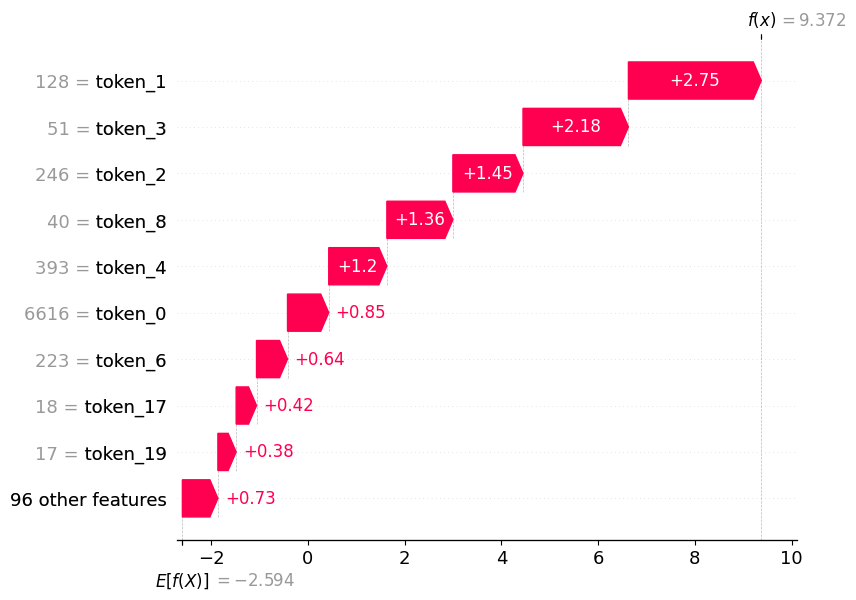

In [ ]:
import shap
import numpy as np

# Background dataset (małe - 100 próbek)
background_size = 100
np.random.seed(42)
background_indices = np.random.choice(len(indeksy_model_1), background_size, replace=False)
X_background = np.asarray(indeksy_model_1['NAZWA_TOKENS_PADDED'].tolist())[background_indices]

# JEDYNA próbka do wyjaśnienia
sample_idx = 42
X_single = np.asarray(indeksy_model_1['NAZWA_TOKENS_PADDED'].tolist())[sample_idx:sample_idx+1]

# TreeExplainer z background dataset
explainer = shap.TreeExplainer(
    model, 
    data=X_background,  # DODANE: background dataset
    feature_perturbation='interventional',
    model_output='raw'
)
shap_values = explainer(X_single, check_additivity=False)

# Przewidywana klasa
predicted_class_idx = model.predict(X_single)[0]
print(f"Przewidywana klasa (indeks): {predicted_class_idx}")
print(f"Nazwa klasy Y: {indeksy_model_1['Y'].unique()[predicted_class_idx]}")

# Wybierz wartości SHAP dla przewidywanej klasy
shap_values_for_predicted_class = shap_values[0, :, predicted_class_idx]

# Waterfall plot
shap.plots.waterfall(shap.Explanation(
    values=shap_values_for_predicted_class,
    base_values=explainer.expected_value[predicted_class_idx],
    data=X_single[0],
    feature_names=[f"token_{i}" for i in range(X_single.shape[1])]
))

PermutationExplainer explainer: 67086it [8:59:02,  2.07it/s]                              

C:\Users\User\AppData\Local\Temp\ipykernel_8896\219050556.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, np.asarray(indeksy_model_1['NAZWA_TOKENS_PADDED'].tolist()))
C:\Users\User\AppData\Local\Temp\ipykernel_8896\219050556.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, np.asarray(indeksy_model_1['NAZWA_TOKENS_PADDED'].tolist()))


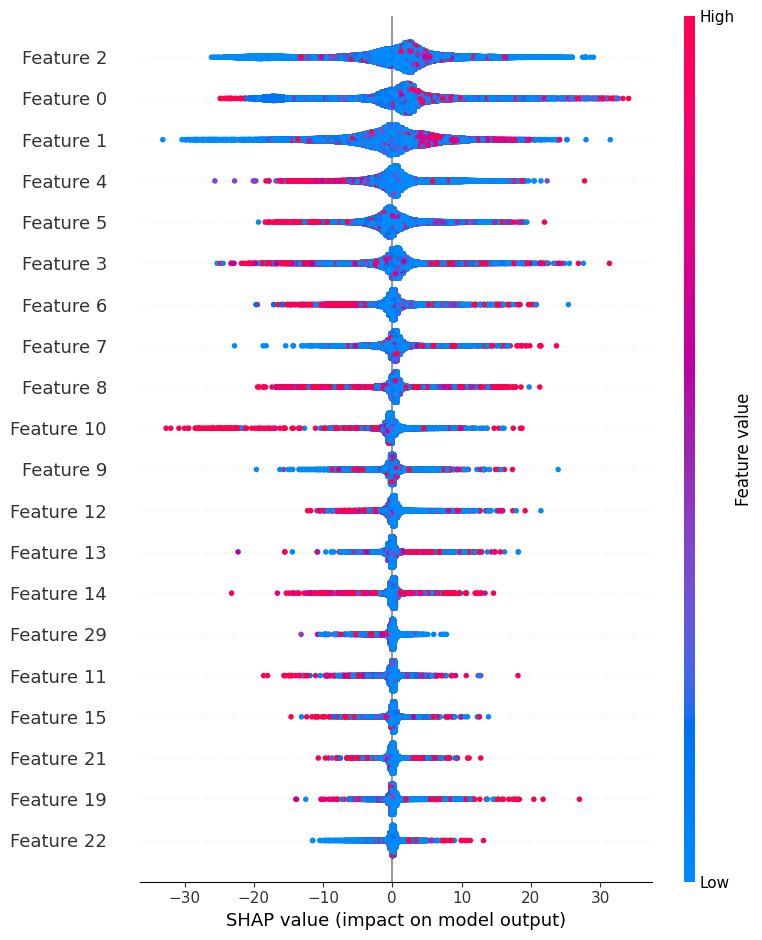

In [ ]:
#Używająć SHAP do interpretacji modelu, określamy, które cechy (tokeny) miały największy wpływ na przewidywania modelu.
#import shap
# Przekaż dane jako numpy array (ma atrybut .shape). pad_tokens teraz zwraca numpy array, ale upewniamy się używając np.asarray
#explainer = shap.TreeExplainer(model.predict, np.asarray(indeksy_model_1['NAZWA_TOKENS_PADDED'].tolist()))
#shap_values = explainer(np.asarray(indeksy_model_1['NAZWA_TOKENS_PADDED'].tolist()))
#shap.summary_plot(shap_values, np.asarray(indeksy_model_1['NAZWA_TOKENS_PADDED'].tolist()))

 

In [ ]:
# Użyj tokenów jako cech zamiast tylko ich liczby
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Przekształć tokeny na macierz cech (np. średnia tokenów, TF-IDF, embeddingi)
max_tokens = indeksy_model_1['NAZWA_tokens'].apply(len).max()
X = np.array([
    np.pad(tokens, (0, max_tokens - len(tokens)), constant_values=0)[:max_tokens]
    for tokens in indeksy_model_1['NAZWA_tokens']
])

# Lub użyj XGBClassifier zamiast XGBRegressor
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

In [ ]:
from Funkcje.tokenizacja import decode_tokens

# dekodowanie przykładowej wartości tokenów z ramki indeksy_df_token
sample_tokens = indeksy_df_token.iloc[3]['NAZWA_tokens']
decoded_text = decode_tokens(sample_tokens)
print(f"Oryginalna nazwa: {indeksy_df_token.iloc[3]['NAZWA']}")
print(f"Zdekodowany tekst: {decoded_text}")
print(f"Liczba tokenów: {len(sample_tokens)}")

Oryginalna nazwa: RURA 168,3X8 X52 PSL1 AT 3.1
Zdekodowany tekst: RURA 168,3X8 X52 PSL1 AT 3.1
Liczba tokenów: 20
